<td>
   <a target="_blank" href="https://labelbox.com" ><img src="https://labelbox.com/blog/content/images/2021/02/logo-v4.svg" width=256/></a>
</td>

<td>
<a href="https://colab.research.google.com/github/Labelbox/labelbox-python/blob/master/examples/basics/export_data.ipynb" target="_blank"><img
src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</td>

<td>
<a href="https://github.com/Labelbox/labelbox-python/tree/master/examples/basics/export_data.ipynb" target="_blank"><img
src="https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white" alt="GitHub"></a>
</td>

# Export data
How to export data for projects, datasets, slices, and models, with examples for each type of v2 export along with details on optional parameters and filters.

In [ ]:
!pip install -q "labelbox[data]"
!pip install -q urllib3 

In [ ]:
import labelbox as lb
import urllib.request
from PIL import Image

# API Key and Client
See the developer guide for [creating an API key](https://docs.labelbox.com/reference/create-api-key).

In [ ]:
API_KEY = ""
client = lb.Client(api_key=API_KEY)

## Export data rows from a project
For complete details on the supported filters and parameters, including how they are used and what information is included, please see the [Export overview](https://docs.labelbox.com/reference/label-export#optional-parameters-and-filters) developer guide.

### Parameters
When you export data rows from a project, you may choose to include or exclude certain attributes, including:
- `attachments`
- `metadata_fields`
- `data_row_details`
- `project_details`
- `label_details`
- `performance_details`
- `interpolated_frames`
    - Only applicable for video data rows.

### Filters
When you export data rows from a project, you can specify the included data rows with the following filters:
- `last_activity_at`
- `label_created_at`
- `data_row_ids`
- `batch_ids`

#### Filter details
You can set the range for `last_activity_at` and `label_created_at` in the following formats: 
- `YYYY-MM-DD`
- `YYYY-MM-DD hh:mm:ss`
- `YYYY-MM-DDThh:mm:ss±hhmm` (ISO 8601)

The ISO 8061 format allows you to specify the timezone, while the other two formats assume timezone from the user's workspace settings.

The `last_activity_at` filter captures the creation and modification of labels, metadata, workflow status, comments, and reviews.

If you wish to specify data rows to export, uncomment the `data_row_ids` filter and provide a list of applicable IDs. The data rows must be part of a batch attached to the project in question. You can provide up to 2,000 data row IDs.

The `batch_ids` filter allows you to specify data rows for export based on their associated batch ID. This is particularly useful when `data_row_ids` is not sufficient due to 2,000 data row IDs limit. 

In [ ]:
# Insert the project ID of the project from which you wish to export data rows.
PROJECT_ID = ""
project = client.get_project(PROJECT_ID)

In [ ]:
# Set the export params to include/exclude certain fields. 
export_params= {
  "attachments": True,
  "metadata_fields": True,
  "data_row_details": True,
  "project_details": True,
  "label_details": True,
  "performance_details": True,
  "interpolated_frames": True
}

# Note: Filters follow AND logic, so typically using one filter is sufficient.
filters= {
  "last_activity_at": ["2000-01-01 00:00:00", "2050-01-01 00:00:00"],
  "label_created_at": ["2000-01-01 00:00:00", "2050-01-01 00:00:00"],
  # "data_row_ids": ["<data_row_id>", "<data_row_id>"],
  # "batch_ids": ["<batch_id>", "<batch_id>"],
}

export_task = project.export_v2(params=export_params, filters=filters)
export_task.wait_till_done()

if export_task.errors:
  print(export_task.errors)

export_json = export_task.result
print("results: ", export_json)

## Export data rows from a dataset
For complete details on the supported filters and parameters, including how they are used and what information is included, please see the [Export overview](https://docs.labelbox.com/reference/label-export#optional-parameters-and-filters) developer guide.

### Parameters
When you export data rows from a dataset, you may choose to include or exclude certain attributes, including:
- `attachments`
- `metadata_fields`
- `data_row_details`
- `project_details`
- `label_details`
- `performance_details`
- `interpolated_frames`
    - Only applicable for video data rows.
- `project_ids`
    - Accepts a list of project IDs. If provided, the labels created _in these projects_ on the exported data rows will be included. 
- `model_run_ids`
    - Accepts a list of model run IDs. If provided, the labels and predicitions created _in these model runs_ will be included. 

### Filters
When you export data rows from a project, you can specify the included data rows with the following filters:
- `last_activity_at`
- `label_created_at`
- `data_row_ids`

See the _Export data rows from a project_ section above for additional details on each filter. 

In [ ]:
# Insert the dataset ID of the dataset from which you wish to export data rows.
DATASET_ID = ""
dataset = client.get_dataset(DATASET_ID)

In [ ]:
# Set the export params to include/exclude certain fields.
export_params= {
  "attachments": True,
  "metadata_fields": True,
  "data_row_details": True,
  "project_details": True,
  "label_details": True,
  "performance_details": True,
  "interpolated_frames": True,
  # "project_ids": ["<project_id>", "<project_id>"],
  # "model_run_ids": ["<model_run_id>", "<model_run_id>"]  
}

# Note: Filters follow AND logic, so typically using one filter is sufficient.
filters= {
  "last_activity_at": ["2000-01-01 00:00:00", "2050-01-01 00:00:00"]
}

export_task = dataset.export_v2(params=export_params, filters=filters)
export_task.wait_till_done()

if export_task.errors:
  print(export_task.errors)

export_json = export_task.result
print("results: ", export_json)

## Export data rows from a slice
For complete details on the supported filters and parameters, including how they are used and what information is included, please see the [Export overview](https://docs.labelbox.com/reference/label-export#optional-parameters-and-filters) developer guide.

### Parameters
When exporting from a slice, you can apply the same parameters as exporting from a dataset.

### Filters
No filters are applicable to exports from a slice. All the data rows of the slice must be exported.

In [ ]:
# Insert the Catalog slice ID of the slice from which you wish to export data rows.
CATALOG_SLICE_ID = ""
catalog_slice = client.get_catalog_slice(CATALOG_SLICE_ID)

In [ ]:
# Set the export params to include/exclude certain fields.
export_params = {
  "attachments": True,
  "metadata_fields": True,
  "data_row_details": True,
  "project_details": True,
  "label_details": True,
  "performance_details": True,
  "interpolated_frames": True,
  # "project_ids": ["<project_id>", "<project_id>"],
  # "model_run_ids": ["<model_run_id>", "<model_run_id>"]
}

export_task = catalog_slice.export_v2(params=export_params)
export_task.wait_till_done()

if export_task.errors:
  print(export_task.errors)

export_json = export_task.result
print("results: ", export_json)

## Export data rows from a model run
For complete details on the supported filters and parameters, including how they are used and what information is included, please see the [Export overview](https://docs.labelbox.com/reference/label-export#optional-parameters-and-filters) developer guide.

### Parameters
- `attachments`
- `metadata_fields`
- `data_row_details`
- `interpolated_frames`
    - Only applicable for video data rows.
- `predictions`
    - If true, all predictions made in the model run will be included for each data row in the export.

### Filters
No filters are applicable to exports from a model run. All the data rows of the model run must be exported.


In [ ]:
# Insert the model run ID of the model run from which you wish to export data rows.
MODEL_RUN_ID = ""
model_run = client.get_model_run(MODEL_RUN_ID)

In [ ]:
# Set the export params to include/exclude certain fields.
export_params = {
  "attachments": True,
  "metadata_fields": True,
  "data_row_details": True,
  "interpolated_frames": True,
  "predictions": True
}

export_task = model_run.export_v2(params=export_params)
export_task.wait_till_done()

if export_task.errors:
  print(export_task.errors)

export_json = export_task.result
print("results: ", export_json)

## How to access a `mask` URL 

Annotations of the kind `ImageSegmentationMask` and `VideoSegmentationMask` can only be present in labels made on image or video data rows, respectively. In order to access the mask data, you must pass your Labelbox API key stored in `client.headers` in an API request.

When you grab a URL from the mask annotation in the export, the `project_id` and `feature_id` will already be in place. Here, we provide the framework for structuring a URL with any project ID and feature ID.

In [ ]:
# Provide a project ID and feature ID. Alternatively, replace the entire mask_url with a URL grabbed from your export.
project_id = ""
feature_id = ""

mask_url = f"https://api.labelbox.com/api/v1/projects/{project_id}/annotations/{feature_id}/index/1/mask"

In [ ]:
# Make the API request 
req = urllib.request.Request(mask_url, headers=client.headers)

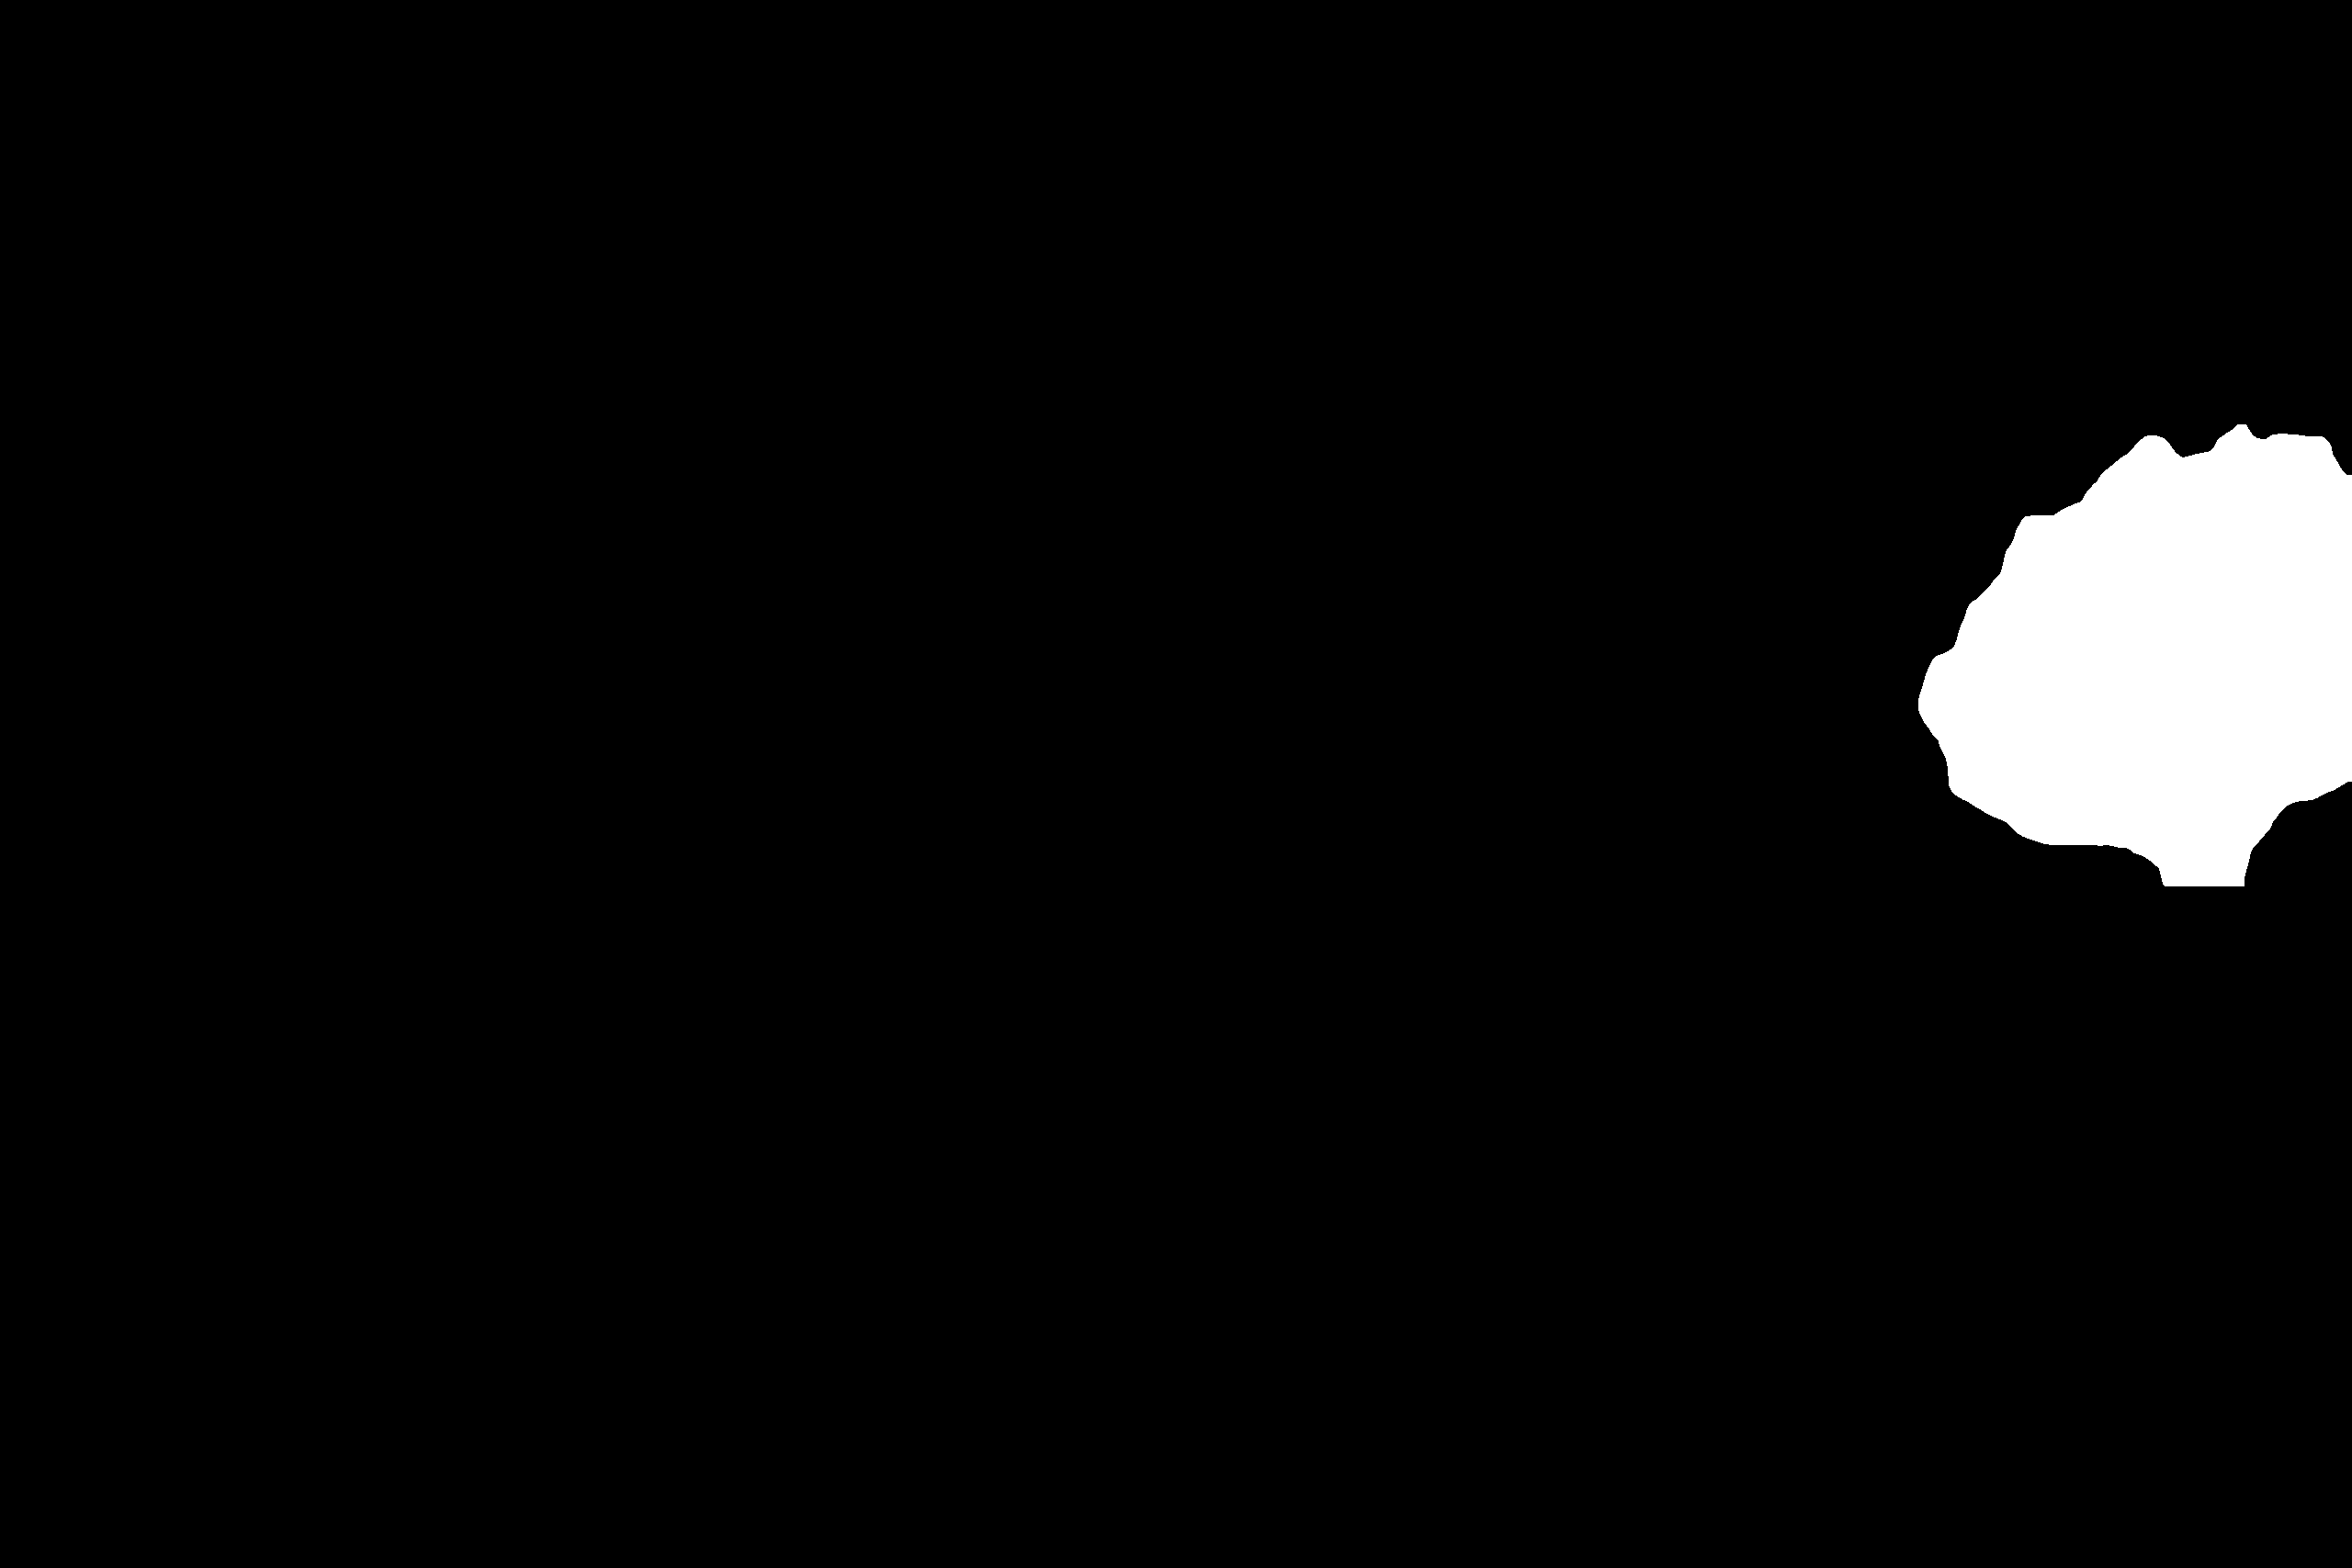

In [ ]:
# Print the image of the mask
image = Image.open(urllib.request.urlopen(req))
image
